In [2]:
#All Libraries used in the code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
#Reading the data from the csv files
hour3 = pd.read_csv('1_6pm - 9pm.csv')
hour6 = pd.read_csv('2_9pm - 12am.csv')
hour9 = pd.read_csv('3_12am - 3am.csv')
hour12 = pd.read_csv('4_3am - 6am.csv')
hour15 = pd.read_csv('5_6am - 9am.csv')
hour18 = pd.read_csv('6_9am - 12pm.csv')
hour21 = pd.read_csv('7_12pm - 3pm.csv')
hour24 = pd.read_csv('8_3pm - 6pm.csv')

hours = [hour3, hour6, hour9, hour12, hour15, hour18, hour21, hour24]

In [4]:
#Cleaning the data
for hour in hours:
    for column in hour.columns[1:]:
        hour[column] = pd.Series(hour[column]).dropna()


In [10]:
#Extract Seen Features
seen_features_dfs = {}
for idx, hour in enumerate(hours):
    features = []
    for column in hour.columns[1:]:
        frequency = hour['Freq_Hz']
        curve = hour[column]
        peaks, _ = find_peaks(curve, height=0)
        peak_amplitudes = curve.iloc[peaks].values
        peak_frequencies = frequency.iloc[peaks].values
        area = np.trapz(curve, frequency)
        num_peaks = len(peaks)

        if len(peak_amplitudes) > 0:
            max_peak_amplitude = np.max(peak_amplitudes)
            avg_peak_frequency = np.mean(peak_frequencies)
        else:
            max_peak_amplitude = 0
            avg_peak_frequency = 0

        features.append({
            'column': column,
            'peak_amplitudes': peak_amplitudes,
            'peak_frequencies': peak_frequencies,
            'area_under_curve': area,
            'num_peaks': num_peaks,
            'max_peak_amplitude': max_peak_amplitude,
            'avg_peak_frequency': avg_peak_frequency
        })

    seen_features_dfs[f'df_{idx}'] = pd.DataFrame(features)

In [5]:
#Auto Encoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

#Creating training AutoEncoder Loop to pull out loss values on each 3 hour period of data 
def train_autoencoder(train_data, test_data, input_dim, latent_dim, epochs=20, batch_size=16, learning_rate=0.001):
    model = Autoencoder(input_dim=input_dim, latent_dim=latent_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(train_data.size()[0])
        
        for i in range(0, train_data.size()[0], batch_size):
            optimizer.zero_grad()
            indices = permutation[i:i + batch_size]
            batch_x = train_data[indices]
            
            outputs = model(batch_x)
            loss = criterion(outputs, batch_x)
            
            loss.backward()
            optimizer.step()
    
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_data)
        test_loss = criterion(test_outputs, test_data)
    
    return test_loss.item()
    

In [6]:
#Function finds the optimal number of latent features to pull from data based on loss values
def find_latent_dims(hour, latent_features_range, epochs=10, batch_size=16, learning_rate=0.001):
    min_loss = float('inf')
    best_latent_dim = None
    
    for latent_dim in latent_features_range:
        total_loss = 0
        
        scaler = MinMaxScaler()
        df_scaled = scaler.fit_transform(hour)
        
        train_data, test_data = train_test_split(df_scaled, train_size=0.8)
        train_data = torch.tensor(np.array(train_data), dtype=torch.float32)
        test_data = torch.tensor(np.array(test_data), dtype=torch.float32)
        
        input_dimensions = df_scaled.shape[1]
        loss = train_autoencoder(train_data, test_data, input_dimensions, latent_dim, epochs, batch_size, learning_rate)
        total_loss += loss

        avg_loss = total_loss / len(hour)
        
        if avg_loss < min_loss:
            min_loss = avg_loss
            best_latent_dim = latent_dim
    
    return best_latent_dim

def latent_labels(num_latent):
    return [f'Latent{i+1}' for i in range(num_latent)]

In [7]:
#Extracting Latent Features via AutoEncoder
latent_features_range = range(1, 15)
latent_features_dfs = {}
idx = 0

for idx, hour in enumerate(hours):
    temp_hour = hour.copy().drop(columns = 'Freq_Hz')
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(temp_hour.transpose())
    
    train_data, test_data = train_test_split(df_scaled, train_size=0.8)

    train_data = torch.tensor(np.array(train_data), dtype=torch.float32)
    test_data = torch.tensor(np.array(test_data), dtype=torch.float32)

    input_dimensions = df_scaled.shape[1]
    latent_dimension = find_latent_dims(hour, latent_features_range)

    model = Autoencoder(input_dim=input_dimensions, latent_dim=latent_dimension)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 10
    batch_size = 16

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(train_data.size()[0])
            
        for i in range(0, train_data.size()[0], batch_size):
            optimizer.zero_grad()
                
            indices = permutation[i:i+batch_size]
            batch_x = train_data[indices]
                
            outputs = model(batch_x)
            loss = criterion(outputs, batch_x)
                
            loss.backward()
            optimizer.step()
            
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        latent_features = model.encoder(torch.tensor(np.array(df_scaled), dtype=torch.float32)).numpy()
        
    latent_features_dfs[f'df_{idx}'] = pd.DataFrame(latent_features, columns=latent_labels(latent_dimension))


Epoch [1/10], Loss: 0.0724
Epoch [2/10], Loss: 0.0729
Epoch [3/10], Loss: 0.0692
Epoch [4/10], Loss: 0.0780
Epoch [5/10], Loss: 0.0700
Epoch [6/10], Loss: 0.0553
Epoch [7/10], Loss: 0.0561
Epoch [8/10], Loss: 0.0540
Epoch [9/10], Loss: 0.0491
Epoch [10/10], Loss: 0.0555
Epoch [1/10], Loss: 0.0651
Epoch [2/10], Loss: 0.0678
Epoch [3/10], Loss: 0.0658
Epoch [4/10], Loss: 0.0625
Epoch [5/10], Loss: 0.0577
Epoch [6/10], Loss: 0.0543
Epoch [7/10], Loss: 0.0490
Epoch [8/10], Loss: 0.0523
Epoch [9/10], Loss: 0.0514
Epoch [10/10], Loss: 0.0423
Epoch [1/10], Loss: 0.0747
Epoch [2/10], Loss: 0.0740
Epoch [3/10], Loss: 0.0673
Epoch [4/10], Loss: 0.0644
Epoch [5/10], Loss: 0.0653
Epoch [6/10], Loss: 0.0548
Epoch [7/10], Loss: 0.0527
Epoch [8/10], Loss: 0.0496
Epoch [9/10], Loss: 0.0478
Epoch [10/10], Loss: 0.0484
Epoch [1/10], Loss: 0.0804
Epoch [2/10], Loss: 0.0714
Epoch [3/10], Loss: 0.0712
Epoch [4/10], Loss: 0.0684
Epoch [5/10], Loss: 0.0643
Epoch [6/10], Loss: 0.0593
Epoch [7/10], Loss: 0.051

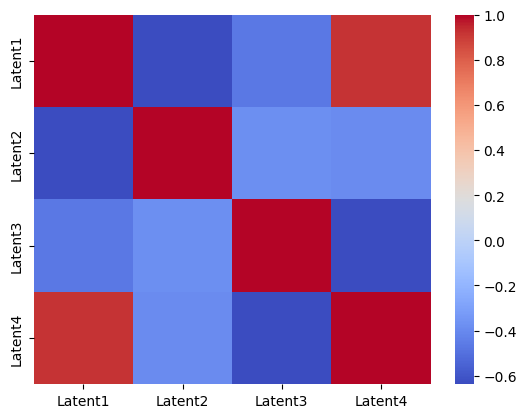

In [8]:
corr_matrix = latent_features_dfs['df_0'].corr()

sns.heatmap(corr_matrix, cmap='coolwarm', fmt='.2f')
plt.show()

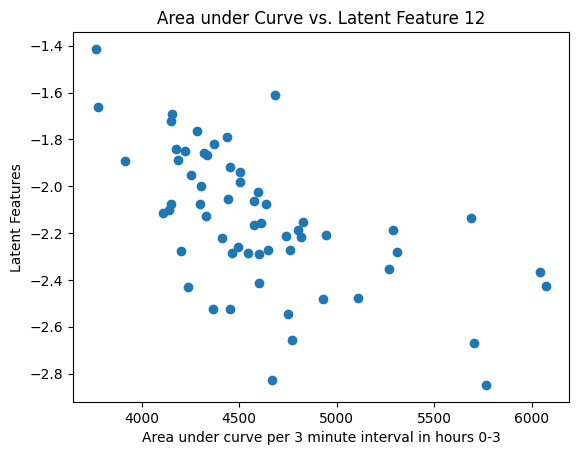

In [18]:
#Scatter plot example of the area under curve for every 3 min interval vs. latent features
plt.scatter(seen_features_dfs['df_0']['area_under_curve'], latent_features_dfs['df_0']['Latent2'])
plt.xlabel('Area under curve per 3 minute interval in hours 0-3')
plt.ylabel('Latent Features')
plt.title('Area under Curve vs. Latent Feature 12')
plt.show()

In [11]:
#printing data
print(seen_features_dfs['df_0']['peak_amplitudes'])

0     [5.718246606, 1.947899715, 1.357474738, 2.0317...
1     [0.949955024, 1.258293177, 2.110102338, 1.8443...
2     [1.449704476, 1.611469752, 1.83321245, 1.22388...
3     [2.878835234, 1.633669683, 1.349114157, 1.8345...
4     [1.22510012, 1.018626858, 1.610458546, 1.81173...
5     [9.006051368, 2.163821602, 1.380010539, 1.7962...
6     [0.898006129, 1.44774443, 0.99623339, 0.964265...
7     [2.432595682, 3.413136777, 1.223040384, 2.3347...
8     [2.549235475, 1.217035557, 1.203636311, 1.6928...
9     [1.522607878, 2.518275753, 2.275261843, 1.4827...
10    [1.451179756, 1.622825648, 3.859137185, 1.0440...
11    [0.641106524, 2.874302229, 1.951238858, 0.9785...
12    [2.340330973, 1.140734567, 1.657566513, 0.8242...
13    [8.673364075, 1.907774983, 0.913216016, 1.6378...
14    [1.597763279, 1.493598414, 1.134530161, 1.7759...
15    [0.994584884, 1.318778222, 1.179772294, 1.7866...
16    [9.690820242, 2.16389347, 1.089559388, 1.20504...
17    [2.863975093, 0.822719226, 2.785295211, 1.

Index(['Latent1', 'Latent2', 'Latent3', 'Latent4'], dtype='object')
Index(['column', 'peak_amplitudes', 'peak_frequencies', 'area_under_curve',
       'num_peaks'],
      dtype='object')
Column 'Freq_Hz' not found in the DataFrame.


ValueError: setting an array element with a sequence.

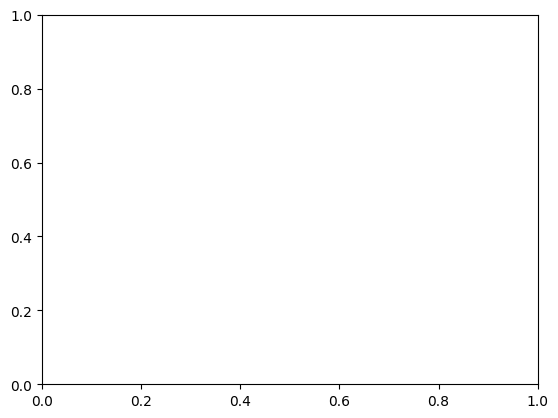

In [13]:
# Check the columns of the DataFrame
print(latent_features_dfs['df_0'].columns)
print(seen_features_dfs['df_0'].columns)

# If the column exists, drop it
if 'Freq_Hz' in latent_features_dfs['df_0'].columns:
    latent_ex = latent_features_dfs['df_0'].drop(['Freq_Hz'])
else:
    print("Column 'Freq_Hz' not found in the DataFrame.")


plt.plot(seen_features_dfs['df_0']['peak_amplitudes'], latent_features_dfs['df_0']['Latent1'])
plt.xlabel('Peak Amplitudes')
plt.ylabel('Latent1')
plt.title('Peak Amplitudes vs. Latent1')
plt.show()

In [14]:
print(seen_features_dfs['df_0']['peak_amplitudes'])

0     [5.718246606, 1.947899715, 1.357474738, 2.0317...
1     [0.949955024, 1.258293177, 2.110102338, 1.8443...
2     [1.449704476, 1.611469752, 1.83321245, 1.22388...
3     [2.878835234, 1.633669683, 1.349114157, 1.8345...
4     [1.22510012, 1.018626858, 1.610458546, 1.81173...
5     [9.006051368, 2.163821602, 1.380010539, 1.7962...
6     [0.898006129, 1.44774443, 0.99623339, 0.964265...
7     [2.432595682, 3.413136777, 1.223040384, 2.3347...
8     [2.549235475, 1.217035557, 1.203636311, 1.6928...
9     [1.522607878, 2.518275753, 2.275261843, 1.4827...
10    [1.451179756, 1.622825648, 3.859137185, 1.0440...
11    [0.641106524, 2.874302229, 1.951238858, 0.9785...
12    [2.340330973, 1.140734567, 1.657566513, 0.8242...
13    [8.673364075, 1.907774983, 0.913216016, 1.6378...
14    [1.597763279, 1.493598414, 1.134530161, 1.7759...
15    [0.994584884, 1.318778222, 1.179772294, 1.7866...
16    [9.690820242, 2.16389347, 1.089559388, 1.20504...
17    [2.863975093, 0.822719226, 2.785295211, 1.

In [15]:
# Simple Linear Regression Model (Consider Ridge or Lasso Regression for overfitting)
pipeline = Pipeline([
    ('scale', MinMaxScaler()),
    ('linear', LinearRegression())
])

#pipeline.fit(x_train, y_test)
#predictions = pipeline.predict(x_train)

#error = root_mean_squared_error(y_train, predictions)

#plt.plot(y_train, predictions, color = 'green')

NameError: name 'Pipeline' is not defined

In [16]:
# Simple Regression Model (Consider Ridge or Lasso Regression for overfitting)
pipeline = Pipeline([
    ('scale', MinMaxScaler()),
    ('polynomial', PolynomialFeatures(degree = 3, include_bias = True))
])

#pipeline.fit(x_train, y_test)
#predictions = pipeline.predict(x_train)

#error = root_mean_squared_error(y_train, predictions)

#plt.plot(y_train, predictions, color = 'purple')

NameError: name 'Pipeline' is not defined